# Image Classification using Tensor Flow

- This notebook consists of code which can be used to train a neural network on different categories of images provided that there are sufficient number of images and tested against a image on which the model is trained

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-01-09 16:49:19.721820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


- Dataset can be downloaded from either internet or can be created manually
- Both techniques have been added into the code based on the requirement
- Assumption here is that, URL will download a .tgz file and hence, paratement: untar is set to True

In [2]:
# loading the datatset from URL

import pathlib
#dataset_url = "<complete_URL>"
#data_dir = tf.keras.utils.get_file('file_name', origin = dataset_url, untar = True)
data_dir = pathlib.Path('/Users/hedago/.keras/datasets/new_images')

In [3]:
# getting image count in dataset

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

61


- Let's view some sample images in the datatset

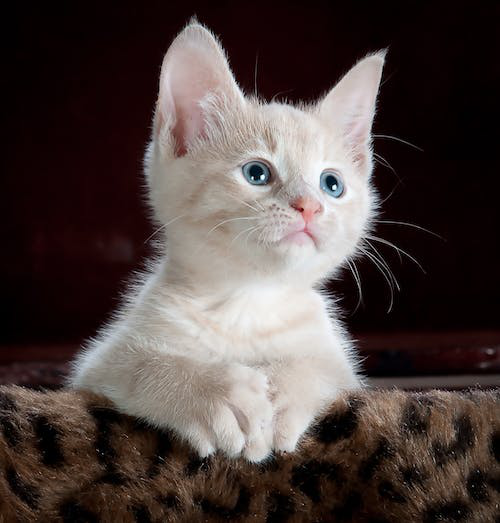

In [4]:
# accessing images of cats

cats = list(data_dir.glob('cats/*'))
PIL.Image.open(str(cats[1]))

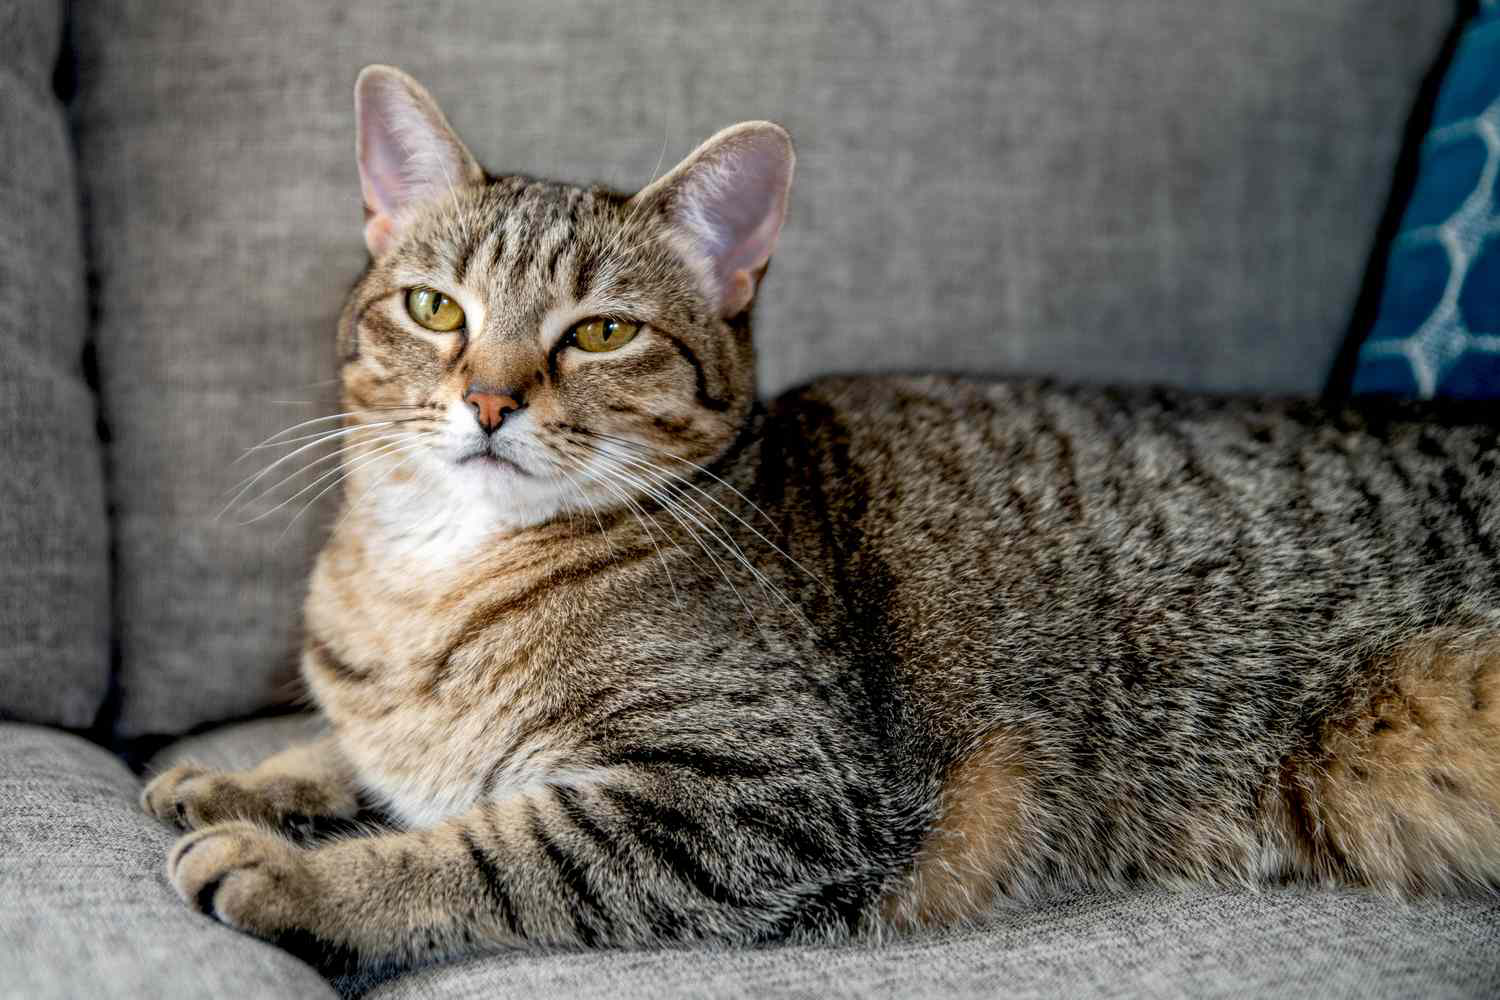

In [5]:
PIL.Image.open(str(cats[3]))

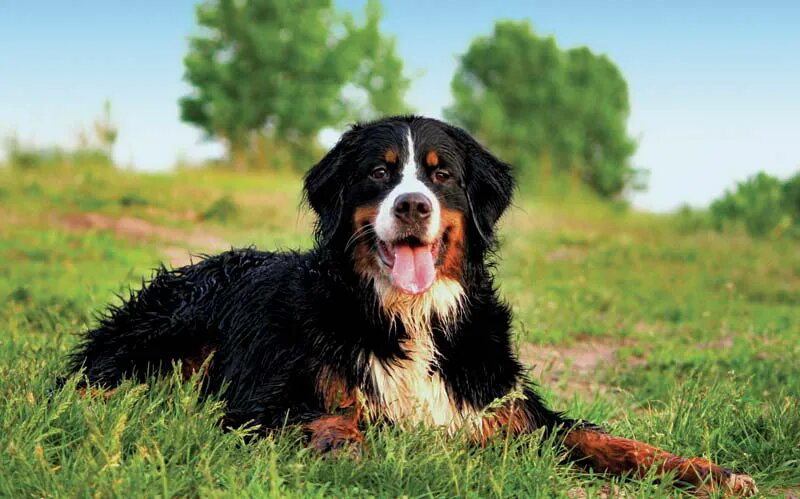

In [6]:
# accessing images for dogs

dogs = list(data_dir.glob('dogs/*'))
PIL.Image.open(str(dogs[5]))

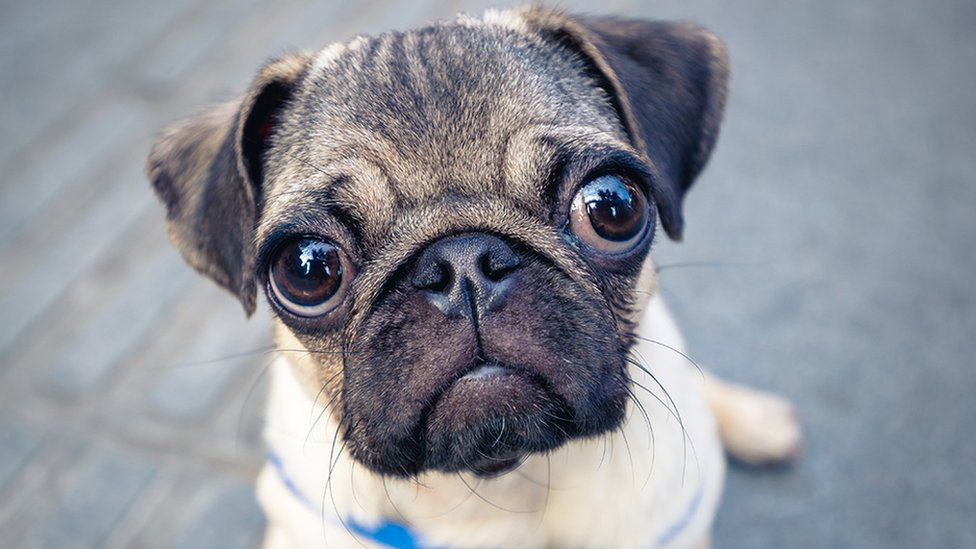

In [7]:
PIL.Image.open(str(dogs[17]))

- **Defining image specification to standardize all the image dimensions**

In [8]:
# setting image size parameters

batch_size = 32
img_height = 180
img_width = 180

- Creating Train and Test datasets with images present in dataset with a 80-20 split

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 61 files belonging to 2 classes.
Using 49 files for training.


2023-01-09 16:49:22.398588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 61 files belonging to 2 classes.
Using 12 files for validation.


In [11]:
# getting class names from trainging dataset

class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


- This piece of code will check for any incompatible/corrupted image if present in the dataset. This is important as model will fail to train with corrupted images

In [12]:
# checking for corrupted images

from pathlib import Path
import imghdr

data_dir = "/Users/hedago/.keras/datasets/new_images"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

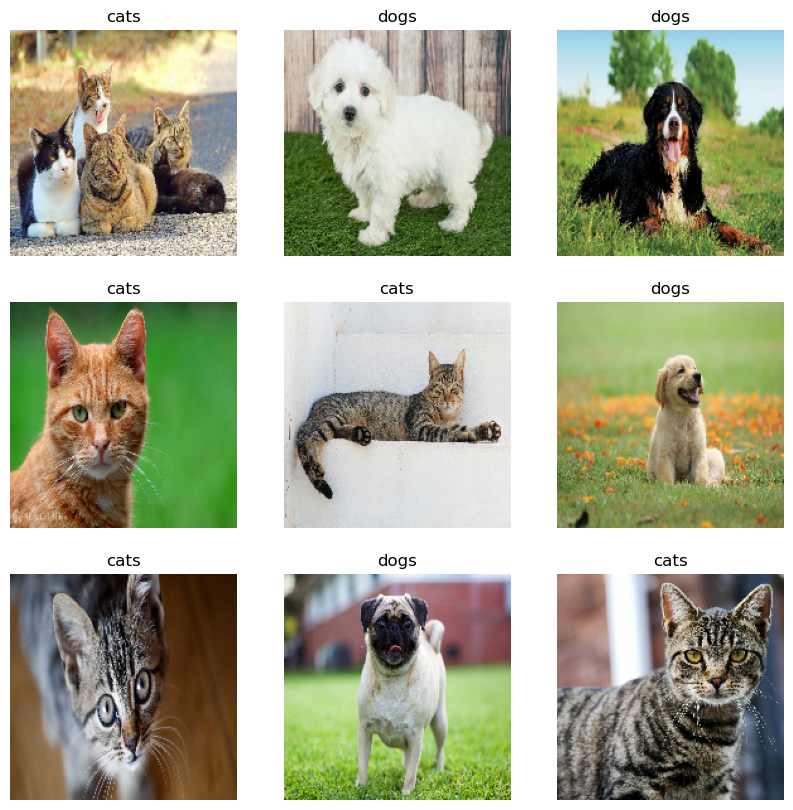

In [13]:
# visualizing sample images using matplotlib

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

- Let us check for the batch size and dimensions of the images

In [14]:
# getting no. of images and dimensions

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


- Image dimensions are 180x180x3 and the batch size is 32 which match the specifications set above

In [15]:
# tuning performance for dataset using dataset.cache and dataset.prefetch

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# standardizing dimensions of image from (0, 255) to (0, 1) for better performance in neural network

normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# the pixel values are now in [0,1].
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
# building Sequential model

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
# compiling model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# getting summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [21]:
# traing the model

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2/2 [==============================] - 1s 370ms/step - loss: 2.1350 - accuracy: 0.4490 - val_loss: 0.6571 - val_accuracy: 0.7500
Epoch 2/10
2/2 [==============================] - 0s 217ms/step - loss: 0.7239 - accuracy: 0.6735 - val_loss: 0.6801 - val_accuracy: 0.5833
Epoch 3/10
2/2 [==============================] - 0s 134ms/step - loss: 0.7054 - accuracy: 0.4898 - val_loss: 0.6858 - val_accuracy: 0.4167
Epoch 4/10
2/2 [==============================] - 0s 132ms/step - loss: 0.6642 - accuracy: 0.5918 - val_loss: 0.7130 - val_accuracy: 0.4167
Epoch 5/10
2/2 [==============================] - 0s 131ms/step - loss: 0.6628 - accuracy: 0.5102 - val_loss: 0.7005 - val_accuracy: 0.4167
Epoch 6/10
2/2 [==============================] - 0s 129ms/step - loss: 0.6398 - accuracy: 0.5918 - val_loss: 0.6854 - val_accuracy: 0.4167
Epoch 7/10
2/2 [==============================] - 0s 211ms/step - loss: 0.6051 - accuracy: 0.7143 - val_loss: 0.6748 - val_accuracy: 0.4167
Epoch 8/10
2/2 [====

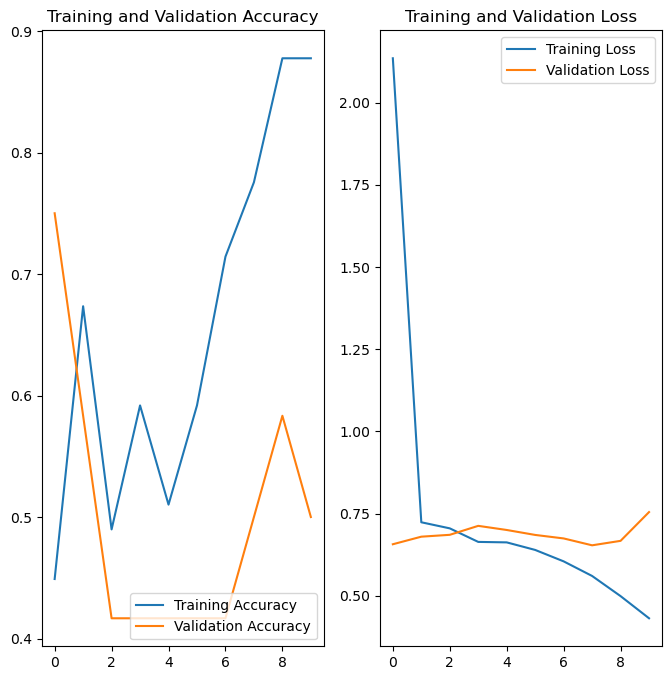

In [22]:
# visualizing training data

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# augumenting data as validation accuracy is around only 60%

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

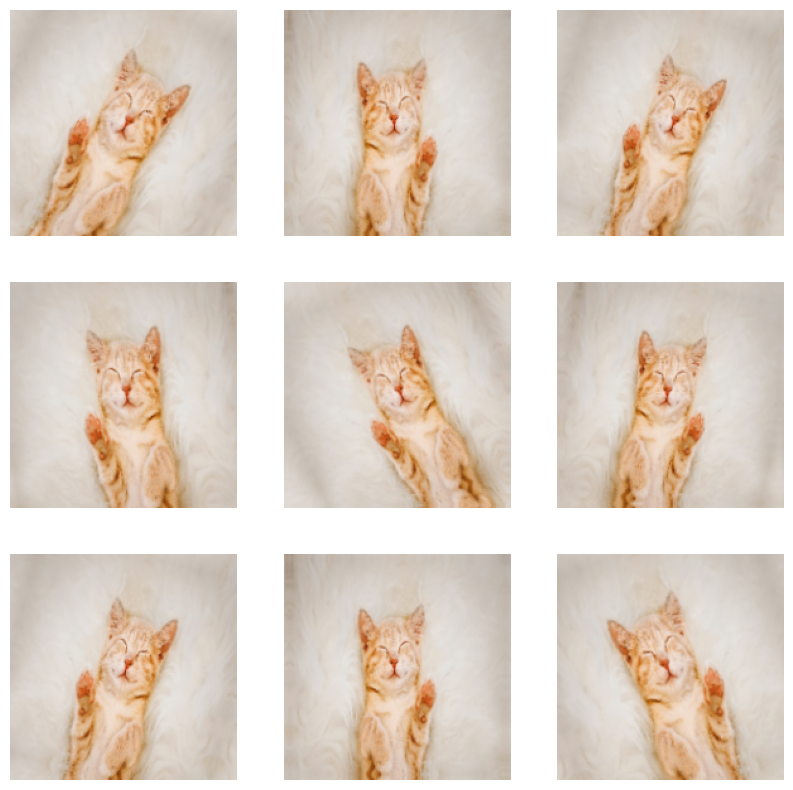

In [24]:
# visualizing augumented data

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
# adding dropout to reduce overfitting 

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [26]:
# re-compiling model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# generating summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [28]:
# running model with 15 epochs

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
2/2 [==============================] - 2s 309ms/step - loss: 0.8707 - accuracy: 0.5102 - val_loss: 1.6401 - val_accuracy: 0.5833
Epoch 2/30
2/2 [==============================] - 0s 253ms/step - loss: 1.3388 - accuracy: 0.4898 - val_loss: 0.6983 - val_accuracy: 0.5000
Epoch 3/30
2/2 [==============================] - 0s 151ms/step - loss: 0.6770 - accuracy: 0.6122 - val_loss: 0.8756 - val_accuracy: 0.4167
Epoch 4/30
2/2 [==============================] - 0s 249ms/step - loss: 0.7217 - accuracy: 0.5102 - val_loss: 0.7712 - val_accuracy: 0.4167
Epoch 5/30
2/2 [==============================] - 0s 242ms/step - loss: 0.6711 - accuracy: 0.5714 - val_loss: 0.7252 - val_accuracy: 0.2500
Epoch 6/30
2/2 [==============================] - 0s 149ms/step - loss: 0.6592 - accuracy: 0.6531 - val_loss: 0.7095 - val_accuracy: 0.4167
Epoch 7/30
2/2 [==============================] - 0s 242ms/step - loss: 0.6318 - accuracy: 0.6735 - val_loss: 0.7491 - val_accuracy: 0.4167
Epoch 8/30
2/2 [====

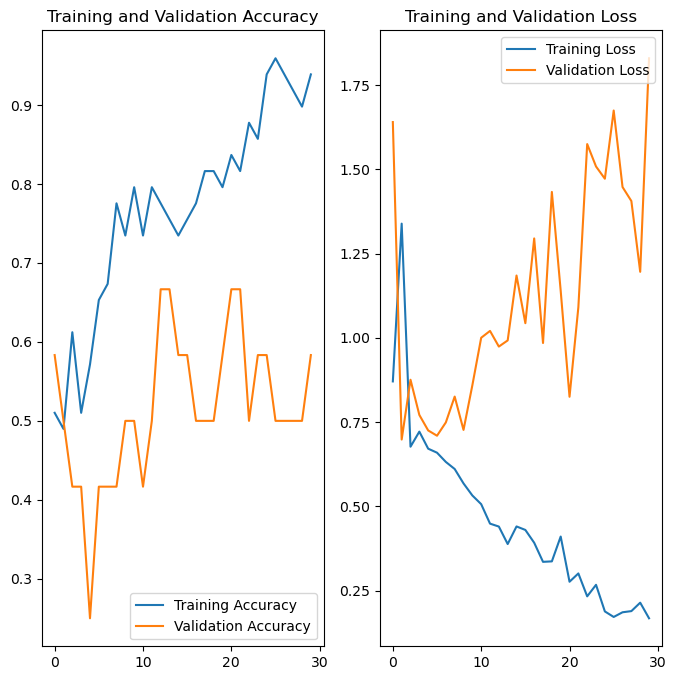

In [29]:
# visualizing training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# since the accuracy improved after adding dropout, predicting on new model

img = tf.keras.utils.load_img(
    '/Users/hedago/.keras/datasets/test_images/cat_test1.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 16ms/step
This image most likely belongs to cats with a 99.91 percent confidence.


- The model is able to determine the animal in the image with a confidence level of 99.91%